# User Segmentation via Clustering

## Objectives

This notebook implements **user segmentation** using clustering algorithms on the aggregated user profile features from previous feature engineering. The goal is to identify distinct user segments to inform marketing strategies, personalization, and retention efforts.

Key priorities:

* Apply clustering algorithms (e.g., KMeans, Agglomerative) to user profile features
* Determine optimal number of clusters and interpret segment characteristics
* Visualize and profile user segments for actionable business insights

---

## Inputs

* `user_profile_features.csv` — aggregated user-level features for clustering

---

## Tasks in This Notebook

1. **Load User Profile Data**  
   Import the feature-engineered user dataset.

2. **Preprocessing**  
   Scale and prepare features for clustering (e.g. normalization, handling missing values).

3. **Clustering Model Selection and Training**  
   Choose and fit clustering algorithms (e.g., KMeans, DBSCAN, Agglomerative).  
   Use methods such as the elbow method or silhouette score to select the optimal number of clusters.

4. **Cluster Evaluation and Profiling**  
   Evaluate cluster quality using silhouette score and other metrics.  
   Analyze and visualize the characteristics of each user segment (e.g., activity, diversity, preferences).

5. **Business Interpretation**  
   Map clusters to actionable marketing or personalization strategies.  
   Document key findings and recommendations.

6. **Save Segmentation Artifacts**  
   Export cluster assignments and summary statistics for downstream use.

---

## Outputs

* User segment assignments and profiles
* Cluster evaluation metrics and visualizations
* Segmentation artifacts saved to `outputs/segmentation/`
* Documentation of segmentation logic and business rationale

>**Note:**  
>This notebook focuses on **user clustering and segmentation** for marketing and personalization.  
>Feature engineering and model training for recommendations are completed in previous notebooks.

# Set up

## Navigate to the Parent Directory

Before combining and saving datasets, it’s often helpful to move to a parent directory so that file operations (like loading or saving data) are easier and more organized. 

Before using the Python’s built-in os module to move one level up from the current working directory, it is advisable to inspect the current directory.

In [1]:
import os

# Get the current working directory
current_dir = os.getcwd()
print(f'Current directory: {current_dir}')

Current directory: c:\Users\reisl\OneDrive\Documents\GitHub\bookwise-analytics\notebooks


To change to parent directory (root folder), run the code below. If you are already in the root folder, you can skip this step.

In [2]:
# Change the working directory to its parent
os.chdir(os.path.dirname(current_dir))
print('Changed directory to parent.')

# Get the new current working directory (the parent directory)
current_dir = os.getcwd()
print(f'New current directory: {current_dir}')

Changed directory to parent.
New current directory: c:\Users\reisl\OneDrive\Documents\GitHub\bookwise-analytics


## Load Datasets

In this step, we load the previously cleaned datasets.

In [3]:
import pandas as pd

data_path = os.path.join(current_dir, "outputs", "datasets", "modeling", "1", "user_profile_features.csv")

user_profiles = pd.read_csv(data_path)

print(f"Loaded user profile features with shape: {user_profiles.shape}")
user_profiles.head()

Loaded user profile features with shape: (53424, 17)


,user_id,rating_count_x,rating_mean,rating_std,pub_year_mean,pages_mean,award_pref,major_pub_pref,genre_count_mean,popularity_mean,num_genres,genre_diversity,genre_concentration,top_genre_share,num_interactions,diversity_category,rating_count_y
0,1,117,3.589744,0.957312,1977.299145,5.904418,0.632479,0.769231,8.324786,4.151893,142.0,4.028370,0.669376,0.091376,974.0,Very High Diversity,117
1,2,65,4.415385,0.845804,1980.738462,5.717231,0.446154,0.615385,7.876923,3.331756,110.0,4.130544,0.563104,0.056641,512.0,Very High Diversity,65
2,3,91,1.736264,0.892377,1965.406593,5.670060,0.505495,0.725275,9.197802,1.863634,145.0,4.251991,0.604936,0.080048,837.0,Very High Diversity,91
3,4,134,3.768657,0.995586,1966.537879,5.774719,0.530303,0.666667,9.083333,4.256617,140.0,4.044631,0.674842,0.093411,1199.0,Very High Diversity,134
4,5,100,4.040000,0.737454,2000.760417,5.755501,0.552083,0.645833,6.947917,1.469687,99.0,3.820972,0.635167,0.097451,667.0,Very High Diversity,100


# Inspect Dataset

We inspect the loaded dataset to understand its structure and contents.

In [4]:
print("DataFrame shape:", user_profiles.shape)
print("\nColumn names:", user_profiles.columns.tolist())
print("\nMissing values per column:\n", user_profiles.isnull().sum())
print("\nSummary statistics:\n", user_profiles.describe(include='all').T)

DataFrame shape: (53424, 17)

Column names: ['user_id', 'rating_count_x', 'rating_mean', 'rating_std', 'pub_year_mean', 'pages_mean', 'award_pref', 'major_pub_pref', 'genre_count_mean', 'popularity_mean', 'num_genres', 'genre_diversity', 'genre_concentration', 'top_genre_share', 'num_interactions', 'diversity_category', 'rating_count_y']

Missing values per column:
 user_id                0
rating_count_x         0
rating_mean            0
rating_std             0
pub_year_mean          0
pages_mean             1
award_pref             0
major_pub_pref         0
genre_count_mean       0
popularity_mean        0
num_genres             1
genre_diversity        1
genre_concentration    1
top_genre_share        1
num_interactions       1
diversity_category     1
rating_count_y         0
dtype: int64

Summary statistics:
                        count unique                  top   freq         mean  \
user_id              53424.0    NaN                  NaN    NaN      26712.5   
rating_coun

# Prepare Data for Clustering

In this step, we preprocess the data to make it suitable for clustering. This includes handling missing values, scaling numerical features, and encoding categorical variables.

In [5]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# impute missing numerical values with median
num_cols = [
    'pages_mean', 'num_genres', 'genre_diversity', 'genre_concentration',
    'top_genre_share', 'num_interactions'
]
num_imputer = SimpleImputer(strategy='median')
user_profiles[num_cols] = num_imputer.fit_transform(user_profiles[num_cols])

# impute missing categorical values with mode
cat_cols = ['diversity_category']
cat_imputer = SimpleImputer(strategy='most_frequent')
user_profiles[cat_cols] = cat_imputer.fit_transform(user_profiles[cat_cols])

# One-hot encode categorical column
user_profiles = pd.get_dummies(user_profiles, columns=cat_cols, drop_first=True)

# scale numerical features
scaler = StandardScaler()
user_profiles[num_cols] = scaler.fit_transform(user_profiles[num_cols])

# drop user_id if not needed for modeling
user_profiles = user_profiles.drop(columns=['user_id'])

# Clustering Pipeline and Evaluation

Now that the data is preprocessed, we will create a clustering pipeline using scikit-learn. This pipeline will ensure that all preprocessing steps (imputation and scaling) are consistently applied before clustering. We will use KMeans as our initial clustering algorithm.

Since clustering is unsupervised, there is no true baseline as in supervised learning. However, we can evaluate the quality of our clusters using internal metrics such as the silhouette score and compare different algorithms or cluster counts to select the best approach.

## KMeans Clustering

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# define numerical columns
num_cols = [
    'pages_mean', 'num_genres', 'genre_diversity', 'genre_concentration',
    'top_genre_share', 'num_interactions'
]

# pipeline for clustering
clustering_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('cluster', KMeans(n_clusters=4, random_state=42))
])

# fit pipeline (X should be only the features used for clustering)
X = user_profiles[num_cols]
clustering_pipeline.fit(X)
labels = clustering_pipeline.named_steps['cluster'].labels_
user_profiles['cluster'] = labels

In [7]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, user_profiles['cluster'])
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.234


In [8]:
cluster_summary = user_profiles.groupby('cluster').mean()
print(cluster_summary)

         rating_count_x  rating_mean  rating_std  pub_year_mean  pages_mean  \
cluster                                                                       
0            130.148335     3.858359    0.887928    1979.070576   -0.030364   
1            106.919412     3.900851    0.878375    1981.197288   -0.190699   
2             84.461955     3.946924    0.867294    1985.029948   -0.550628   
3            107.270176     4.036873    0.814250    1998.037826    0.549387   

         award_pref  major_pub_pref  genre_count_mean  popularity_mean  \
cluster                                                                  
0          0.539139        0.684627          8.521560         2.967698   
1          0.515412        0.659285          8.302409         2.684133   
2          0.500499        0.630365          8.145253         2.732792   
3          0.507359        0.654905          8.544331         2.508763   

         num_genres  genre_diversity  genre_concentration  top_genre_share  \
cl

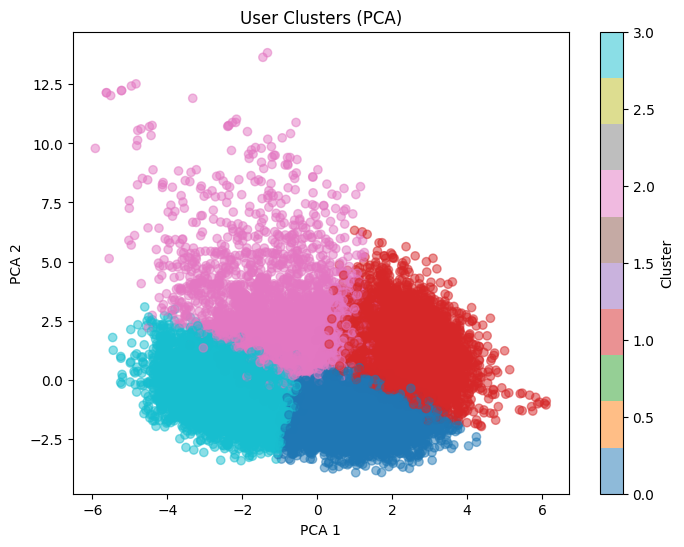

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
components = pca.fit_transform(X)
plt.figure(figsize=(8,6))
plt.scatter(components[:,0], components[:,1], c=user_profiles['cluster'], cmap='tab10', alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('User Clusters (PCA)')
plt.colorbar(label='Cluster')
plt.show()

With `k=4`, user segments become nuanced:

- **Cluster 0:** Highest number of ratings, lowest average rating, prefers older books, moderate genre diversity.
- **Cluster 1:** Moderate ratings, slightly higher average rating, prefers somewhat newer books, highest genre diversity, least focused on a single genre.
- **Cluster 2:** Fewest ratings, high average rating, prefers mid-range publication years, lower genre diversity.
- **Cluster 3:** Moderate ratings, highest average rating, prefers the newest and longest books, lowest genre diversity, most focused on a single genre.

This segmentation might be useful for highly targeted marketing strategies, as it captures a wider variety of user preferences and behaviors, but may also lead to smaller segments that are harder to act upon. We will further analyze different number of clusters to find the optimal balance.

## Test Different Numbers of Clusters and Evaluate

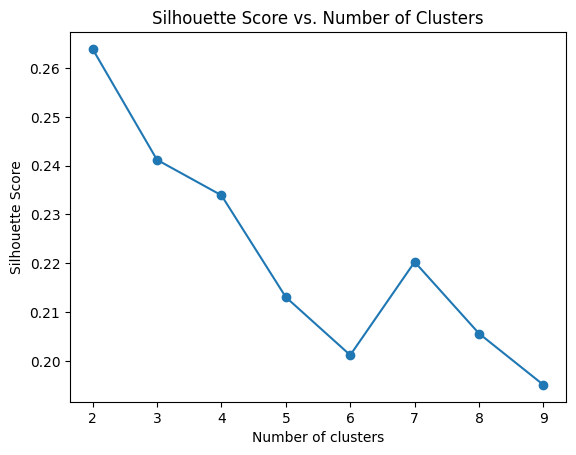

In [10]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    scores.append(silhouette_score(X, labels))

plt.plot(K, scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

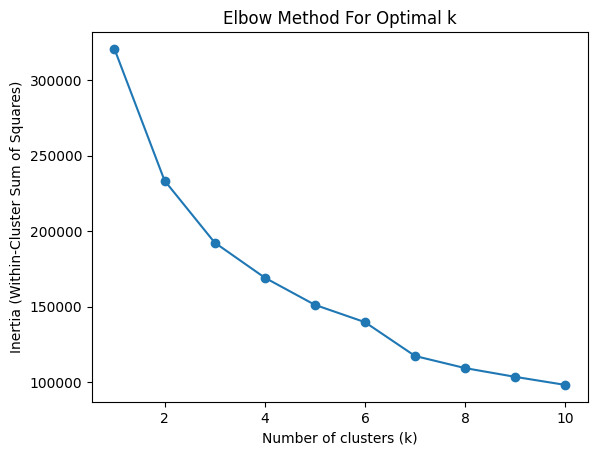

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal k')
plt.show()

### Silhouette Score and Elbow Method: Analysis

Both the silhouette score and the elbow method indicate that k=2 is the optimal number of clusters for your data. The highest silhouette score is at k=2, and it decreases as k increases. This suggests that the clusters are most well-defined when k=2. The inertia drops sharply until k=2, then the decrease becomes more gradual. The "elbow" (where the curve bends) is also around k=2.

In [12]:
# use data above to determine optimal_k
optimal_k = 2
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_profiles['cluster'] = final_kmeans.fit_predict(X)

Cluster Profile (mean values):
         rating_count_x  rating_mean  rating_std  pub_year_mean  pages_mean  \
cluster                                                                       
0            103.177631     3.990070    0.839155    1993.089533    0.291191   
1            118.975571     3.878176    0.882925    1979.267464   -0.238107   

         award_pref  major_pub_pref  genre_count_mean  popularity_mean  \
cluster                                                                  
0          0.511821        0.654392          8.444509         2.644934   
1          0.526151        0.669390          8.402627         2.845796   

         num_genres  genre_diversity  genre_concentration  top_genre_share  \
cluster                                                                      
0         -0.843738        -0.842581             0.135869         0.612341   
1          0.689924         0.688978            -0.111100        -0.500711   

         num_interactions  rating_count_y 

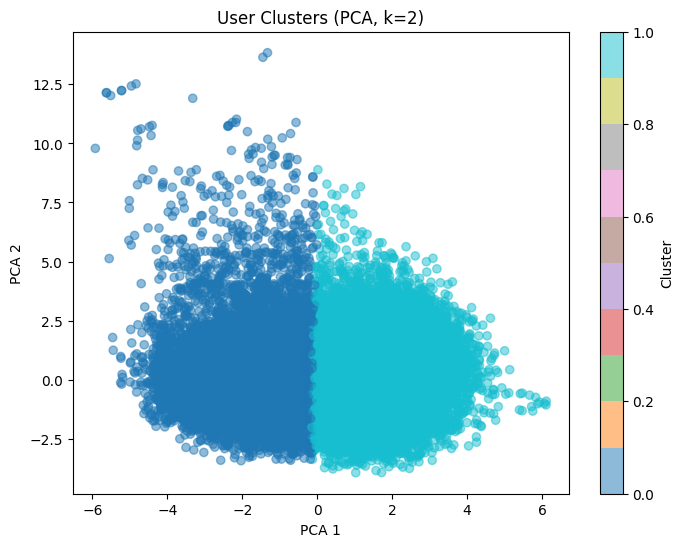

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

cluster_profile = user_profiles.groupby('cluster').mean()
print("Cluster Profile (mean values):")
print(cluster_profile)

print("\nCluster Sizes:")
print(user_profiles['cluster'].value_counts())

pca = PCA(n_components=2)
components = pca.fit_transform(X)
plt.figure(figsize=(8,6))
plt.scatter(components[:,0], components[:,1], c=user_profiles['cluster'], cmap='tab10', alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('User Clusters (PCA, k={})'.format(optimal_k))
plt.colorbar(label='Cluster')
plt.show()

### Cluster Analysis Summary

Based on the clustering results, users were segmented into two distinct groups with the following characteristics:

#### **Cluster 0:**
- Fewer ratings overall
- Higher average rating per book
- Preference for newer and longer books
- Less genre diversity and more focused on a single genre

#### **Cluster 1:**
- More ratings overall
- Slightly lower average rating per book
- Preference for older and shorter books
- Higher genre diversity and less focused on a single genre

#### **Business Interpretation**

- **Cluster 0: "Genre Specialists"**  
  These users tend to focus on specific genres, rate fewer books, and show a preference for newer, longer titles. They may respond well to targeted recommendations within their favorite genres and new releases.

- **Cluster 1: "Genre Explorers"**  
  These users read and rate more books, explore a wider variety of genres, and are more likely to engage with older and shorter books. They may appreciate diverse recommendations and discovery-oriented features.

Understanding these segments can help tailor marketing strategies, personalize recommendations, and improve user engagement for each group.

# Save Model

In [14]:
import os
import joblib

v = '1'

model_dir = os.path.join("outputs", "models", "kmeans", v)
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "kmeans_model.pkl")
joblib.dump(final_kmeans, model_path)

print(f"KMeans model saved to: {model_path}")

KMeans model saved to: outputs\models\kmeans\1\kmeans_model.pkl


In [15]:
import os
from dotenv import load_dotenv
from huggingface_hub import HfApi
from pathlib import Path

v = '1'
load_dotenv() 
# Set up Hugging Face API
api = HfApi()
repo_id = "revolucia/bookclub-cluster"
repo_type = "model"
HF_TOKEN = os.getenv("HUGGINGFACE_CLUSTER_TOKEN")

model_dir = Path(f"outputs/models/kmeans/{v}/")
model_path = model_dir / "kmeans_model.pkl"

if model_path.exists() and HF_TOKEN:
    print(f"Uploading model: {model_path.name} ...")
    api.upload_file(
        path_or_fileobj=str(model_path),
        path_in_repo=f"modeling_data/{model_path.name}",
        repo_id=repo_id,
        repo_type=repo_type,
        token=HF_TOKEN
    )
    print(f"Uploaded: {model_path.name}\n")
else:
    print(f"File not found or missing HF_TOKEN: {model_path}")

print("Model upload process completed.")

Uploading model: kmeans_model.pkl ...


kmeans_model.pkl:   0%|          | 0.00/215k [00:00<?, ?B/s]

Uploaded: kmeans_model.pkl

Model upload process completed.
